1) Read in all files
2) See how many 0's, 1's
3) Analyze file (see the average length) 

In [124]:
import os

replay_path = "c:\\data\\label\\"
for dirName, subdirList, fileList in os.walk(replay_path):
    zeros = [f for f in fileList if f.split(".csv")[0].split("_",2)[2] == '0']
    ones = [f for f in fileList if f.split(".csv")[0].split("_",2)[2] == '1']
print(f"Zeros: {len(zeros)}\nOnes: {len(ones)}")
    

Zeros: 81
Ones: 82


In [125]:
import pandas as pd

all_files = zeros + ones
file_lengths = []
for f in all_files:
    df = pd.read_csv(os.path.join(replay_path,f))
    file_lengths.append(df.shape[0])
pd.Series(file_lengths).describe()


count    163.000000
mean     532.128834
std      190.734809
min      199.000000
25%      352.500000
50%      560.000000
75%      676.000000
max      999.000000
dtype: float64

4) For each file, take 5 seconds before and 1 second after the event of interest (sampling every 0.5 seconds)

In [126]:
sample_interval = 0.5
seconds_before = 5
seconds_after = 1

all_seqs = []
for file in all_files:
    df = pd.read_csv(os.path.join(replay_path,file),index_col=0)
    min_dist = df['hausdorff_distance'].min()
    min_dist_idx = df['hausdorff_distance'].idxmin()
    start_idx = min_dist_idx - seconds_before * (2*sample_interval/0.05)
    stop_idx = min_dist_idx + seconds_after * (2*sample_interval/0.05)

    indices_to_sample = []
    for x in range(int(start_idx),int(stop_idx+1),int(sample_interval/0.05)): indices_to_sample.append(x)

    columns_of_interest = ['hausdorff_distance','angle',
        'ego_vel_x','ego_vel_y','ego_vel_z','ego_accel_x','ego_accel_y','ego_accel_z','ego_ang_vel_x','ego_ang_vel_y','ego_ang_vel_z',
        'adv_vel_x','adv_vel_y','adv_vel_z','adv_accel_x','adv_accel_y','adv_accel_z','adv_ang_vel_x','adv_ang_vel_y','adv_ang_vel_z']
    try:
        rows_of_interest = df.loc[indices_to_sample,columns_of_interest]
    except:
        print(f"bad keys in file {file}")
        print(indices_to_sample)
        continue
    one_seq = []
    for index, rows in rows_of_interest.iterrows():
        for elem in rows:
            one_seq.append(elem)
    one_seq.append(file.split(".csv")[0].split("_",2)[2])
    all_seqs.append(one_seq)

full_df = pd.DataFrame(all_seqs, columns=(columns_of_interest * 13 + ['class']))
full_df.to_csv("c:\\data\\labeled_data.csv",index=None)
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163 entries, 0 to 162
Columns: 261 entries, hausdorff_distance to class
dtypes: float64(260), object(1)
memory usage: 332.5+ KB


5) Generate Train/Test Files

In [127]:
from sklearn.model_selection import train_test_split
x = full_df.iloc[:,:-1]
y = full_df.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.33)
train = x_train.assign(Class=y_train)
test = x_test.assign(Class=y_test)
train.to_csv('c:\\data\\train_file.csv',index=None)
test.to_csv('c:\\data\\test_file.csv',index=None)


In [128]:
x_train.head()

,hausdorff_distance,angle,ego_vel_x,ego_vel_y,ego_vel_z,ego_accel_x,ego_accel_y,ego_accel_z,ego_ang_vel_x,ego_ang_vel_y,...,ego_ang_vel_z,adv_vel_x,adv_vel_y,adv_vel_z,adv_accel_x,adv_accel_y,adv_accel_z,adv_ang_vel_x,adv_ang_vel_y,adv_ang_vel_z
69,4.804101,-12.881412,0.000000,0.000000,0.000000,-0.000379,0.000338,0.004396,0.000000,0.000000,...,-12.949948,-2.255785,-0.012032,0.033104,-0.034804,-0.029997,0.063688,-0.024455,1.007186,-0.483603
17,13.249923,62.585010,-2.308186,1.386937,0.001394,-1.270194,0.531402,0.019874,0.637522,-0.641907,...,-7.557425,0.079160,1.819304,0.004376,0.001116,-0.000415,-0.000051,0.000002,-0.001772,0.631114
131,20.180907,25.367182,0.017822,-2.725851,-0.014760,0.087332,1.670351,-0.024398,-0.602065,0.300137,...,2.524114,-0.570459,-0.102015,-0.004476,-1.870226,-2.904076,-0.134481,1.427664,-1.117837,13.360203
157,27.305255,-9.541705,0.594406,2.634125,0.011978,-0.205472,-1.087093,-0.023164,0.153793,-0.296720,...,-5.094246,0.090938,-0.538257,-0.006299,1.137899,0.872842,0.081033,0.003181,1.021081,6.790780
47,24.966700,26.746358,0.000038,0.000058,0.000041,-0.000108,-0.000215,0.018877,0.021906,-0.010041,...,-0.000037,-3.512770,1.941485,0.000338,1.667356,-0.921493,-0.008146,-0.115338,-0.180198,-0.001246


In [129]:
from sklearn.metrics import accuracy_score,r2_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

RF = RandomForestClassifier()
RF.fit(x_train,y_train)
RF.score(x_test,y_test)

0.9814814814814815

[(160, 'hausdorff_distance', 0.07464341669546254), (240, 'hausdorff_distance', 0.07355022516522744), (200, 'hausdorff_distance', 0.07306242841242165), (220, 'hausdorff_distance', 0.06335885008945948), (180, 'hausdorff_distance', 0.05028367058524046), (140, 'hausdorff_distance', 0.0440691128473076), (120, 'hausdorff_distance', 0.03127462726101232), (100, 'hausdorff_distance', 0.018411558802846527), (1, 'angle', 0.012491813254935218), (236, 'adv_accel_z', 0.011897600333751675), (81, 'angle', 0.011762607577193034), (80, 'hausdorff_distance', 0.011735061616063261), (60, 'hausdorff_distance', 0.010830555429396947), (246, 'ego_accel_y', 0.010334827761506127), (41, 'angle', 0.00916215563333974), (21, 'angle', 0.00878825126102936), (61, 'angle', 0.008706493591696706), (213, 'adv_vel_z', 0.008567587276599807), (133, 'adv_vel_z', 0.008496988583084026), (158, 'adv_ang_vel_y', 0.007479265843277676)]
7.6923076923076925


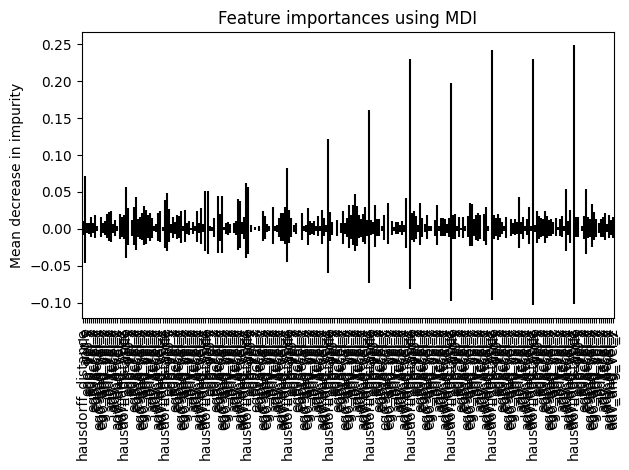

In [130]:
importances = RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in RF.estimators_], axis=0)
feature_names=x_test.columns.values.tolist()
forest_importances = pd.Series(importances, index=feature_names)

#print(np.sort(importances)[::-1])
sorted_importances = np.argsort(importances)[::-1]
sorted_tuple = [(i,feature_names[i],importances[i]) for i in sorted_importances]
print(sorted_tuple[:20])
print(len([x for x in sorted_tuple if x[2]==0])/len(sorted_tuple) * 100)



forest_importances.to_csv("forest_importance.csv")

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std,ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


